# Implémentation d'une régression logistique avec descente de gradient et de l'algorithme 'One vs all'

Nous allons dans cet article procéder à l'implémentation d'un algorithme de machine learning : la régression logisitique. Celui-ci est un algorithme de classification, c'est à dire qu'il permet de prédire à partir de variables $x_i$ (ou features) données si l'observation appartient à une classe ($y = 1$) ou non ($y = 0$).  
Concrétement, il peut être utilisé pour déterminer si un mail reçu est un spam ou non en fonction du titre, de l'objet, du contenu, etc. Mais également savoir si un client sera toujours client dans 6 mois en fonction de sa consommation, de sa satisfaction, etc. Ou encore pour détecter si un cancer est bénin ou non en fonction de sa taille, de son emplacement, ...  
Nous allons donc voir ici comment implémenter un tél algorithme de 0, "from scratch" en essayant d'expliquer l'intuition derrière le code. Ensuite, nous verrons comment appliquer ce problème lorsque l'on a plusieurs classes, c'est à dire que la variable à expliquer peut prendre plus d'une valeur. Comme exemple de problème multiclasse, on peut prendre la classification de client : dans quelle catégorie rentre mon client en fonction de son comportement et de données dont je dispose sur lui.

##  Régression logistique

### Séléction des données et visualisation

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

train_df = pd.read_csv('train.csv')
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Le dataset utilisé ici est le dataset 'titanic' de Kaggle. On effectue un premier tri en enlevant toutes les variables inutiles (comme le nom ou l'id).

In [81]:
columns = ['Fare','Pclass','Age','Survived']
subdataset = train_df[columns]
subdataset.head(10)

,Fare,Pclass,Age,Survived
0,7.2500,3,22.0,0
1,71.2833,1,38.0,1
2,7.9250,3,26.0,1
3,53.1000,1,35.0,1
4,8.0500,3,35.0,0
5,8.4583,3,NaN,0
6,51.8625,1,54.0,0
7,21.0750,3,2.0,0
8,11.1333,3,27.0,1
9,30.0708,2,14.0,1


On enlève également les lignes nulles ou NaN non utilisables.

In [82]:
# Suppression des null
subdataset = subdataset.dropna()

In [83]:
print(subdataset.isnull().sum())

Fare        0
Pclass      0
Age         0
Survived    0
dtype: int64


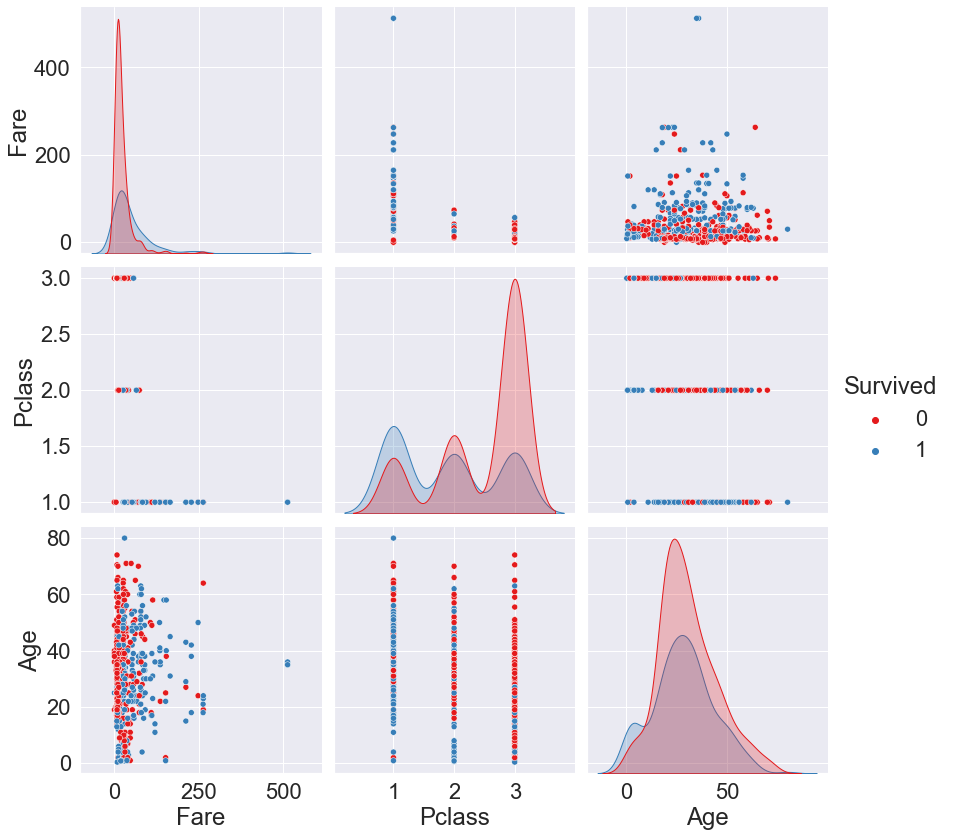

In [84]:
sns.set(font_scale=2)
sns.pairplot(subdataset, hue = 'Survived', palette = 'Set1', diag_kind = 'kde', height = 4)
#Répartition des survivants en fonction des différents paramètres

On observe que globalement, les survivants et non survivants sont distribués de façon uniformes par rappport à nos différents paramètres. On remarque néanmoins que les individus présents en 3ème classe semble avoir une chance de survie plus élevée. Voyons cela plus en détail avec des graphiques individuels :

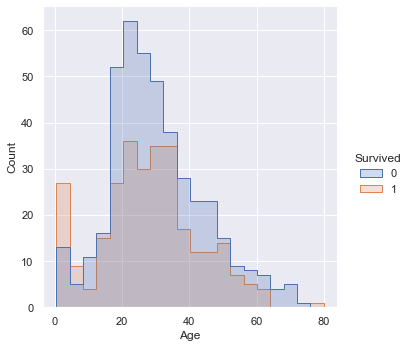

In [85]:
sns.set(font_scale=1)
sns.displot(subdataset, x="Age", hue="Survived", element="step")

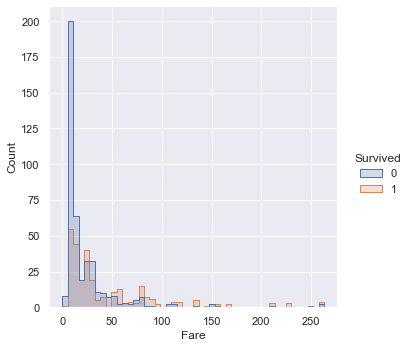

In [86]:
sns.set(font_scale=1)
subdataset = subdataset[subdataset.Fare < 500]
sns.displot(subdataset, x="Fare", hue="Survived", element="step")

On constate que la majorité des gens n'ayant pas survécu au naufrage sont ceux disposant de ticket à faible coût.

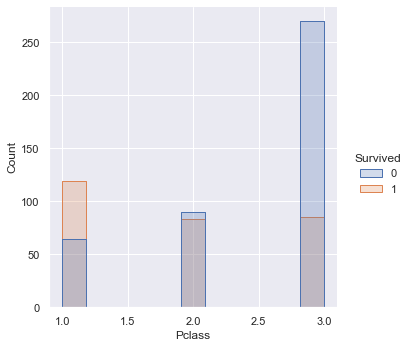

In [87]:
sns.set(font_scale=1)
sns.displot(subdataset, x="Pclass", hue="Survived", element="step")

On observe qu'une part plus importante des individus voyageant en 3e classe à survécue par rapport aux 2 autres classes.

### Implémentation du modèle

Seule la classe ('Pclass') semble avoir un impact significatif sur le fait de survivre au naufrage, nous allons donc implémenter une régression logistique prenant comme feature ce seul paramètre.

In [88]:
X = subdataset[['Pclass']].values # La matrice des features
y = subdataset['Survived'].values # La variable à observer

y = y.reshape((y.shape[0],1))

X = (X-np.mean(X))/np.std(X) # Standardisation des données pour optimiser le temps de calcul

X = np.hstack((X, np.ones((X.shape[0],1)))) # Ajout du biais à la matrice des features
theta =  np.random.rand(X.shape[1],1) # Création du vecteur theta

La régression logistique utilise la fonction sigmoïde définie par :
$\frac{1}{1+\exp(-z)}$. 
En voici la définition et sa représenation graphique :

In [89]:
def g(z):
    return 1/(1+np.exp(-z)) #Définition de la  fonction sigmoide

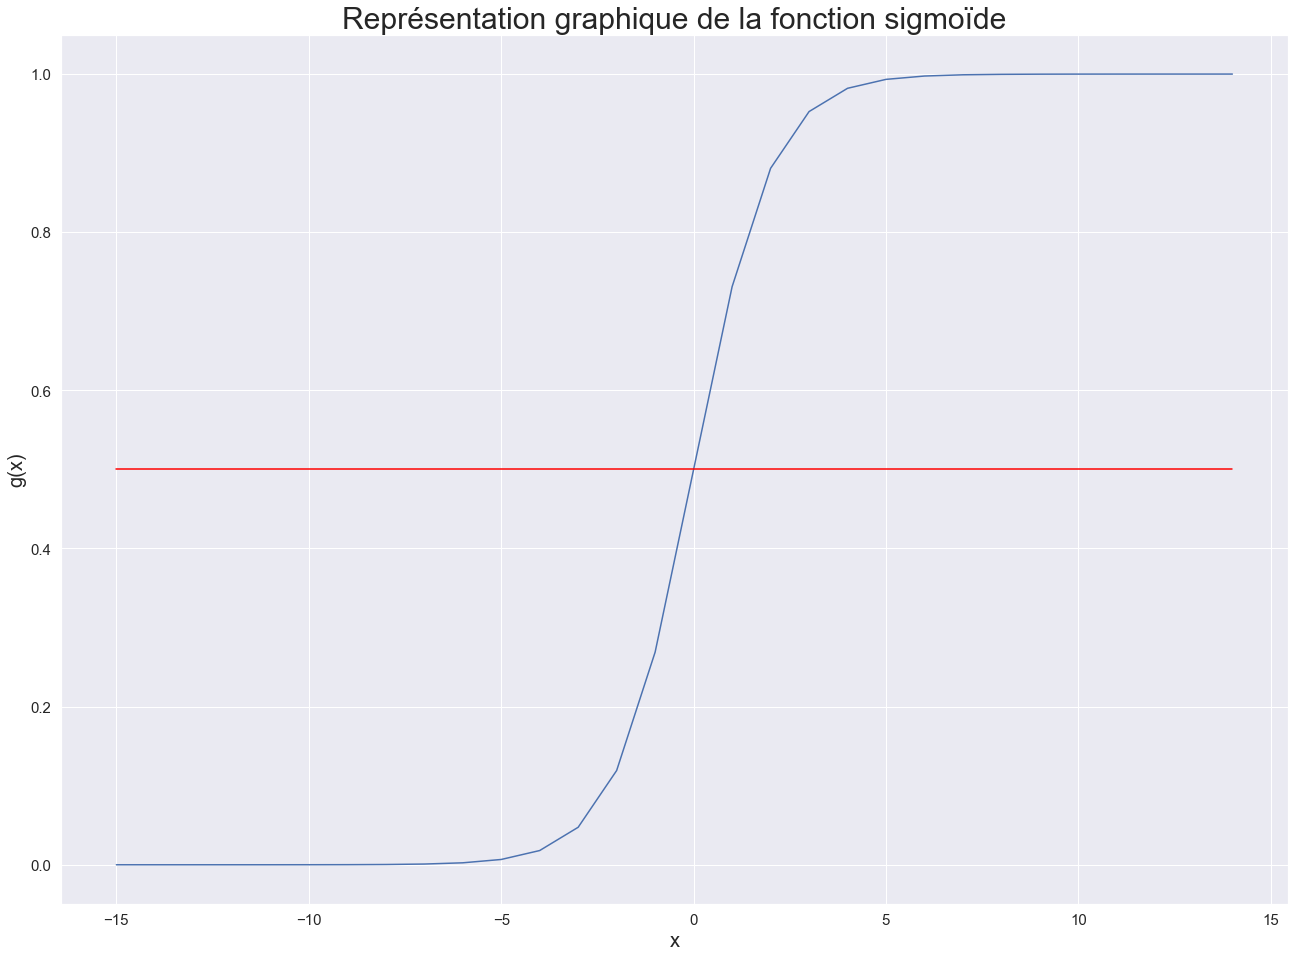

In [90]:
## Représentation graphique
listIndex = list()
listSigmoid  = list()
listO = list()
listA = list()
for i in range(-15, 15, 1):
    listO.append(0.5)
    listIndex.append(i)
    listSigmoid.append(g(i))
    listA.append(0)
plt.figure(figsize=(22,16))
plt.plot(listIndex, listSigmoid)
plt.plot(listIndex, listO, c = 'red')
plt.title('Représentation graphique de la fonction sigmoïde', fontsize = 30)
plt.xlabel('x', fontsize = 20)
plt.ylabel('g(x)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

<p> 
On observe donc que $g(x)$ est borné en $0$ quand il tend vers $-\infty$ et que $g(x)$ est borné en $1$ quand il tend vers $ \infty$. De ce fait, toutes les valeurs possibles pour $g(x)$ sont comprisent dans l'intervalle $[0;1]$.
</p>
<p> 
Dans le cadre de cette régression logistique, l'équation utilisée est similaire à l'équation de la fonction sigmoïde, hormis le fait qu'on remplace le terme $z$ par l'équation : $\theta_0 + \theta_1x_1$.</p>
<p>
Cela nous donne donc : $ h_\theta (x) = g(\theta_0 + \theta_1x_1) = \frac{1}{1+\exp(-\theta_0 + \theta_1x_1)}$.
</p>
<p> 
Dans cette équation, $x_1$ correspond à la feature, soit la variable explicative 'Pclass' et $ \theta_1 $ correspond au 'poids' de cette variable dans le modèle. $\theta_0$ est quand à lui un autre coefficient pondérateur du modèle. 
</p>
<p>
Ainsi, le résultat de notre prédiction sera toujours compris entre $0$ et $1$. Il peut être vu comme la probabilité que l'évènement soit observé, i.e : $ P(X = 1) $, ce qui dans notre cas, correspond à la probabilité que l'individu survive au naufrage du titanic.</p>
<p>
La droite tracée en rouge pour $g(x) = 0.5$ va jouer comme critère de décision, si la probabilité obtenue est supérieure à cette valeur, le modèle prédira que l'individu survive, sinon non. De manière plus formelle  on a :  
Si $P(X=1) >= \alpha$ alors $h_{\theta}(x) = 1$ et si $P(X=1) < \alpha$ alors $h_{\theta}(x) = 0$ avec $\alpha = 0.5$.
</p>

In [91]:
def hypothesis(X, theta):
    return g(np.dot(X, theta))

On définit ici l'équation du modèle (ou hypothèse) définit plus haut. On a toutefois recourt à la [vectorisation](https://medium.com/analytics-vidhya/vectorized-implementation-of-gradient-descent-in-linear-regression-12a10ea37210) (au lieu de traiter les variables une par une, on les 'range' dans des matrices). Cela dans un soucis de clarté, d'optimisation et de simplicité du code.

In [92]:
def J(X, theta, y):
    h = hypothesis(X, theta)
    return (1/len(y)) * sum(np.dot(-y.T, np.log(h))-np.dot((1-y).T, np.log(1-h)))

Une notion fondamentale en machine learning est la fonction de coût, c'est elle qui permet au modèle d'apprendre et donc de s'améliorer. Une fonction de coût est une métrique d'erreur permettant une mesure de l'erreur. L'erreur d'un modèle correspond en fait à la différence entre ce qui à été prédit par le modèle et la réalité observée. Il existe nombre de fonctions de coûts comme la [MSE](https://www.freecodecamp.org/news/machine-learning-mean-squared-error-regression-line-c7dde9a26b93/) (Mean Squared Error) par exemple.  
<p>
    Dans le cadre de notre modèle de régression logistique, on utilise la fonction suivante :
$J(\theta_0, \theta_1) = -\frac{1}{m} \times \sum_{i=1}^{m}[y^{(i)} \times ln(h_\theta(x^{(i)}) + (1-y^{(i)}) \times ln (1-h_\theta(x^{(i)}))]$ ou $m$ correspond au nombre d'observations total de notre dataset et $x^{(i)}$ correspond à la valeur de $x$ pour la $i_{ième}$ observation (de même pour $y^{(i)}$).
</p>
<p>
    Par exemple, si le 5e individu de notre dataset à voyagé en 2e classe et à survecu alors on a : $x^{(5)} = 2$ et $y^{(5)} = 1$. 
<p>
    Cette équation peut sembler complexe mais l'intution derrière est en fait assez simple. On sait que $y$ peut prendre deux valeurs : 0 (l'événement ne s'est pas produit) ou 1 (l'événement s'est produit). De plus, si la probabilité résultant de notre fonction hypothèse $h_\theta(x)$ est loin de la réalité, c'est à dire qu'on obtient une probabilité proche de 0 quand y = 1 ou proche de 1 quand y = 0, on veut mesurer un coût important. C'est précisément ce qu'on obtient avec les termes : $ln(h_\theta(x^{(i)})$ et $ln(1 - h_\theta(x^{(i)}))$.
</p>
<p>
    Maintenant, pourquoi multiplier ces termes par $y$ et $(1-y)$? Et bien, on peut voir ces termes comme des interrupteurs : En effet quand y = 0, le premier terme de l'équation est nul. Ainsi, on va juste mesurer l'erreur avec le second terme, pénalisant quand $h_\theta(x)$ est loin de 0. A l'inverse quand y = 1, c'est le deuxième terme qui est nul. De ce fait, on mesure l'erreur uniquement avec le premier terme, pénalisant quand $h_\theta(x)$ est loin de 1.
</p>
<p>
    On répète alors ce processus pour chaque observation et on additionne le résultat à chaque fois, puis on divise par le nombre d'observation ce qui nous donne une sorte d'erreur moyenne. A noter qu'on multiplie également par -1 car les résultats obtenus dans les $ln$ sont négatifs (puisque la fonction hypothèse renvoie des résultats entre 0 et 1 et que le logarithme de tels valeurs est négatif), on inverse ainsi le signe. Egalement, on peut observer que la fonction $J$ prend comme seuls paramètres $\theta_0$ et $\theta_1$. Ainsi, le seul moyen d'améliorer la précision du modèle est de jouer sur ces $\theta$, car $x$ et $y$ sont des variables données.
</p>


In [127]:
def gradient(X, theta, y):
    h = hypothesis(X, theta)
    return np.dot(X.T, h-y)/len(y)

In [128]:
def gradient_descent(X, theta, y, alpha = 0.05, nbr_iter = 2000):
    lossList = list()
    for i in range(nbr_iter):
        lossList.append(J(X, theta, y))
        theta = theta - alpha * gradient(X, theta, y)
    return theta, lossList

<p>
    A présent que nous avons défini notre modèle et notre fonction de coût, nous allons maintenant voir comment un modèle de machine learning apprend. Cela en implémentant un algorithme couramment utilisé en machine learning : la descente de gradient.
</p>
<p>
    Pour comprendre la descente de gradient, imaginez une station de ski dont le domaine skiable serait sur 2 flancs de montagne séparés par un col. Au niveau du col se trouve le parking. Imaginez maintenant que vous êtes dans cette station sur le flanc de gauche et que vous voulez rejoindre votre voiture. Pour se faire rien de plus simple, il suffit de se tourner vers la pente et de glisser vers le bas (vers la droite donc). Si par hasard vous attrapez un télésiège au passage qui vous emmène vers l'autre flanc de montagne, il suffit alors de descendre vers la gauche. Enfin vous arriverez au parking, et donc au point le plus bas de la station. La descente de gradient fonctionne sur le même principe.
</p>
<p>
    Imaginez une fonction de coût dont la représentation graphique est en forme de parabole (en "U"). L'objectif est d'arriver en bas du "U", car le point le plus bas correspond au minimum de la fonction de coût. En arrivant au minimum de la fonction de coût, on obtient la valeur de $\theta$ pour laquelle l'écart mesuré entre ce que prédit le modèle et ce qui est effectivement observé est le plus faible. En d'autres termes, on obtient la valeur pour laquelle le modèle est le plus performant possible.
</p>
<p>
    Pour descendre le long de cette fonction, on commence par se placer en un point aléatoire de la courbe. Ensuite, on observe la pente de la courbe, si celle ci est positive, on se situe à gauche du minimum, si elle est négative on se situe à droite. Mathématiquement, pour observer cette pente, on calcule la dérivée partielle. On avance ensuite dans cette direction d'un certain pas fixé à l'avance, le learning rate ($\alpha$). On réitére le processus jusqu'à arriver a une convergence, ce qui signifie qu'on à atteint le minimum. Mathématiquement on peut l'écrire:
    $\theta_j := \theta_j - \alpha \times \frac{\delta J(\theta)}{\delta \theta_j}$.   
    
Voyons cela plus en pratique.

In [95]:
theta, lossList = gradient_descent(X, theta, y)

On calcule la matrice des paramètres $\theta$ optimale avec l'algorithme de descente de gradient.

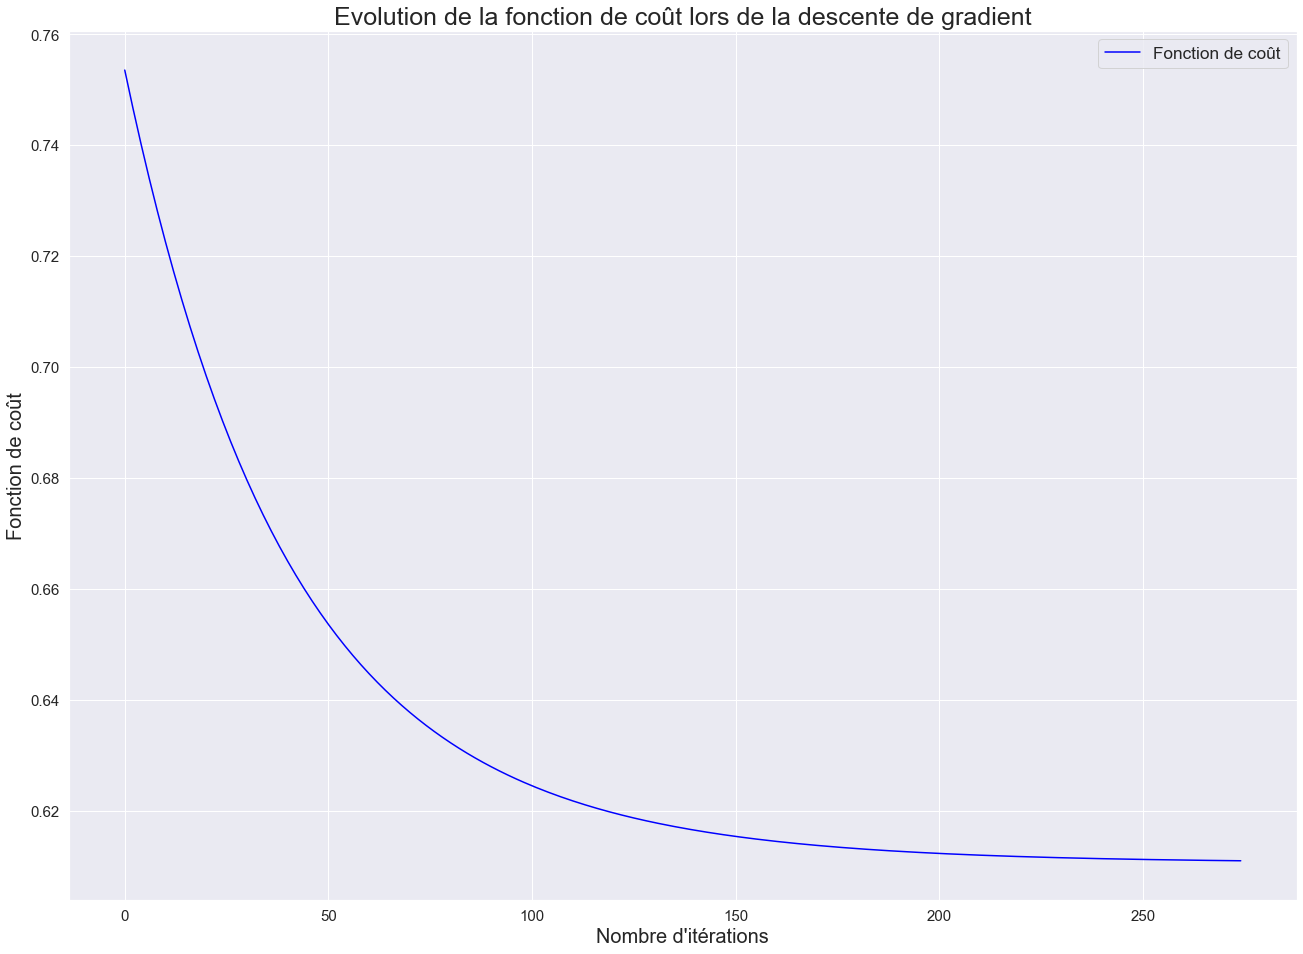

In [96]:
plt.figure(figsize = (22,16))
plt.plot(range(len(lossList[:275])), lossList[:275], c = 'blue', label = 'Fonction de coût')
plt.xlabel('Nombre d\'itérations', fontsize = 20)
plt.ylabel('Fonction de coût', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Evolution de la fonction de coût lors de la descente de gradient',  fontsize = 25)
plt.legend(fontsize = 'x-large')
plt.show()

Voici la représentation graphique de la valeur de la fonction de coût en fonction des 275 premières itérations de la descente de gradient. On voit bien que la fonction converge, on a donc obtenu le $\theta$ optimal pour notre modèle.

In [97]:
def predictions(X, theta):
    h = hypothesis(X, theta)
    for i in range(len(h)):
        if(h[i] >= 0.5):
            h[i] = 1
        else:
            h[i] = 0
    return h
pred = predictions(X, theta)

On applique notre fonction de prédiction déterminant la valeur prédite $0$ ou $1$ en fonction de la probabilité obtenue via la fonction d'hypothèse. Pour rappel, nous nous étions fixés le seuil à $0.5$.

In [118]:
def confusion_Matrix(pred, y):
    # Création de la matrice
    matrix = np.zeros((2,2))
    for i in range(pred.shape[0]):
        if(pred[i] == 0 and y[i] == 0):
            matrix[0][0] += 1
        elif(pred[i] == 0 and y[i] == 1):
            matrix[0][1] += 1
        elif(pred[i] == 1 and y[i] == 0):
            matrix[1][0] += 1
        else:
            matrix[1][1] += 1
            
    # Représentation graphique
    plt.figure(figsize=(22,16))
    sns.heatmap(matrix, 
        xticklabels=['Positive','Negative'],
        yticklabels=['Positive','Negative'],
        linewidths=.5,
        annot=True,
        annot_kws={"size": 24},
        fmt='g',
        cmap = 'seismic')
    plt.title('Matrice de confusion', fontsize = 30)
    plt.xlabel('True class', fontsize = 25)
    plt.ylabel('Predicted class', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    acc = (matrix[0][0]+matrix[1][1])/pred.shape[0]
    print('Accuracy = '+str(acc))
    return matrix

### Résultats et conclusion

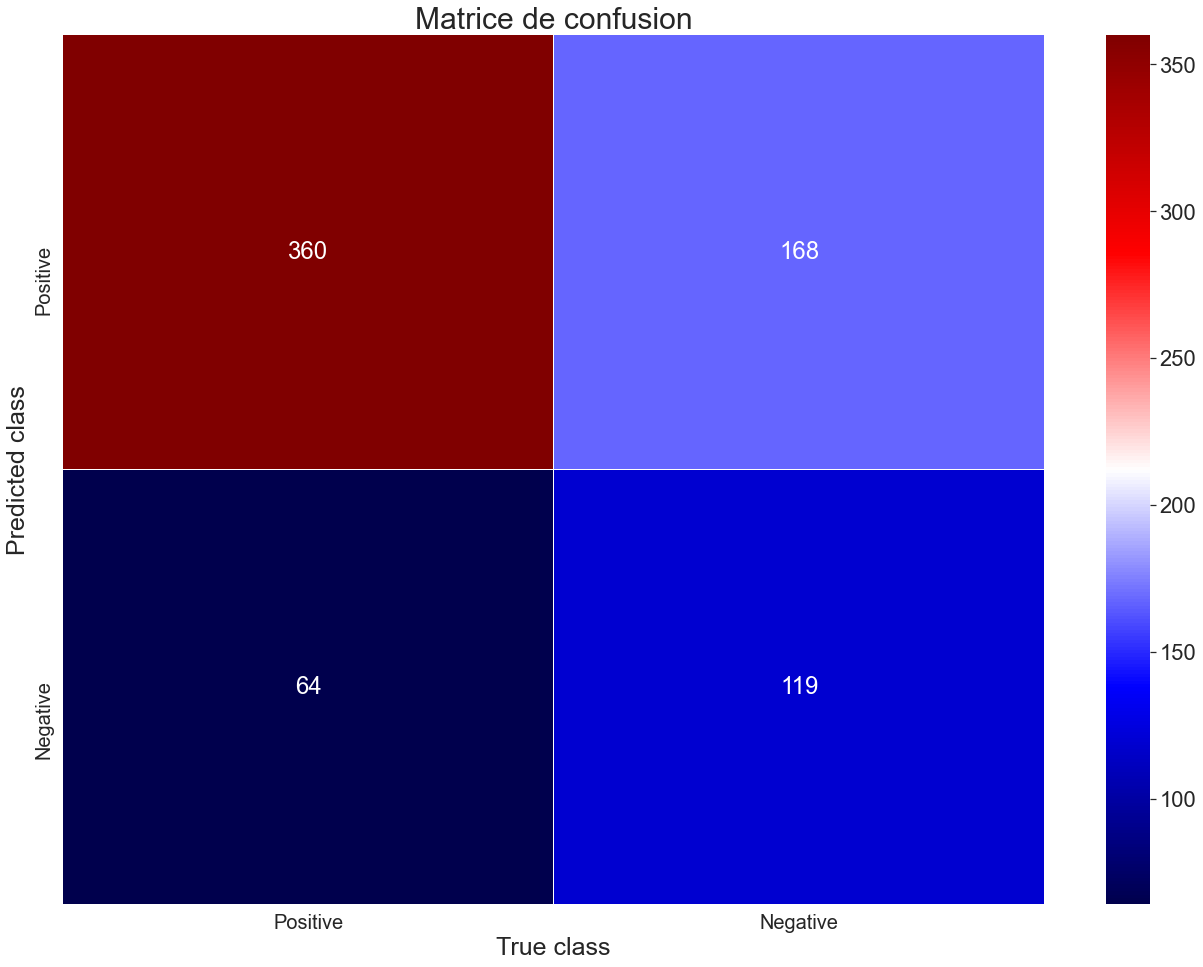

Accuracy = 0.6736990154711674


In [119]:
confusion_matrix = confusion_Matrix(pred, y)

<p>
Voici la matrice de confusion obtenue à partir des prédictions du modèle. Sur l'entrée de gauche, on peut observer les prédictions du modèle ('Positive' signifie que le modèle prédit que l'individu à survécu et 'Négative' signifie que le modèle prédit que l'individu ne survit pas). Sur  l'entrée du bas, c'est la même chose sauf qu'il ne s'agit pas ici des prédictions du modèle mais de ce qu'il s'est effectivement passé. Ainsi, en faisant la somme de la diagonale, on obtient le nombre de prédictions exactes total du modèle soit $360 + 119 = 479$. On peut diviser ce nombre par le nombre d'observations total, et l'on obtient un taux de précision de $67.3$%.
</p>
<p>
    La valeur obtenue est relativement faible pour être vraiment satisfaisante. Il faudrait un taux de précision aux alentours de 80-90% pour avoir un vrai bon modèle. Cela vient sans doute du fait qu'on a pris comme seule feature la variable 'Pclass'. Il faudrait tester avec d'autres features, en les mettant au carré en les multipliants les unes aux autres, etc.
</p>

## ONE VS ALL CLASSIFICATION


Dans cette partie, nous allons aborder la classification multiclasse. Cela signifie qu'il n'y a plus que deux choix possible, mais 3, 4, 5, etc. Dans l'exemple qui va suivre, nous traitons de l'état de santé de bébés. Il s'agit de déterminer si son état est 'Normal' ($y=1$), 'Suspect' ($y=2$) ou 'Pathological' ($y=3$).

A première vue, la régression logistique n'est pas pertinente car elle ne permet de ne prédire que deux états. Toutefois il est quand même possible de résoudre ce problème avec cet algorithme. L'idée est que nous allons séparer notre problème en deux problèmes distincts :
* Le bébé est 'Normal' (y = 0) ou le bébé est 'Suspect' (y = 1)
* Le bébé est 'Normal' (y = 0) ou le bébé est 'Pathological' (y = 1)  
    
On peut alors utiliser la régression logistique pour ces 2 problèmes générant alors une probabilité pour que le bébé soit 'Suspect' ou 'Pathological'. Si les 2 probabilités sont inférieurs à 0.5, on considère que le bébé est 'Normal', sinon c'est le maximum des 2 probabilités qui l'emporte.

### Séléction des données et visualisation

In [130]:
health_dataset = pd.read_csv('fetal_health.csv')
health_dataset.head(10)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.000,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.000,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,0.001,0.0,0.010,0.009,0.0,0.002,26.0,5.9,0.0,...,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,0.001,0.0,0.013,0.008,0.0,0.003,29.0,6.3,0.0,...,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.000,0.0,0.000,0.000,0.0,0.000,83.0,0.5,6.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.000,0.0,0.002,0.000,0.0,0.000,84.0,0.5,5.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.000,0.0,0.003,0.000,0.0,0.000,86.0,0.3,6.0,...,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


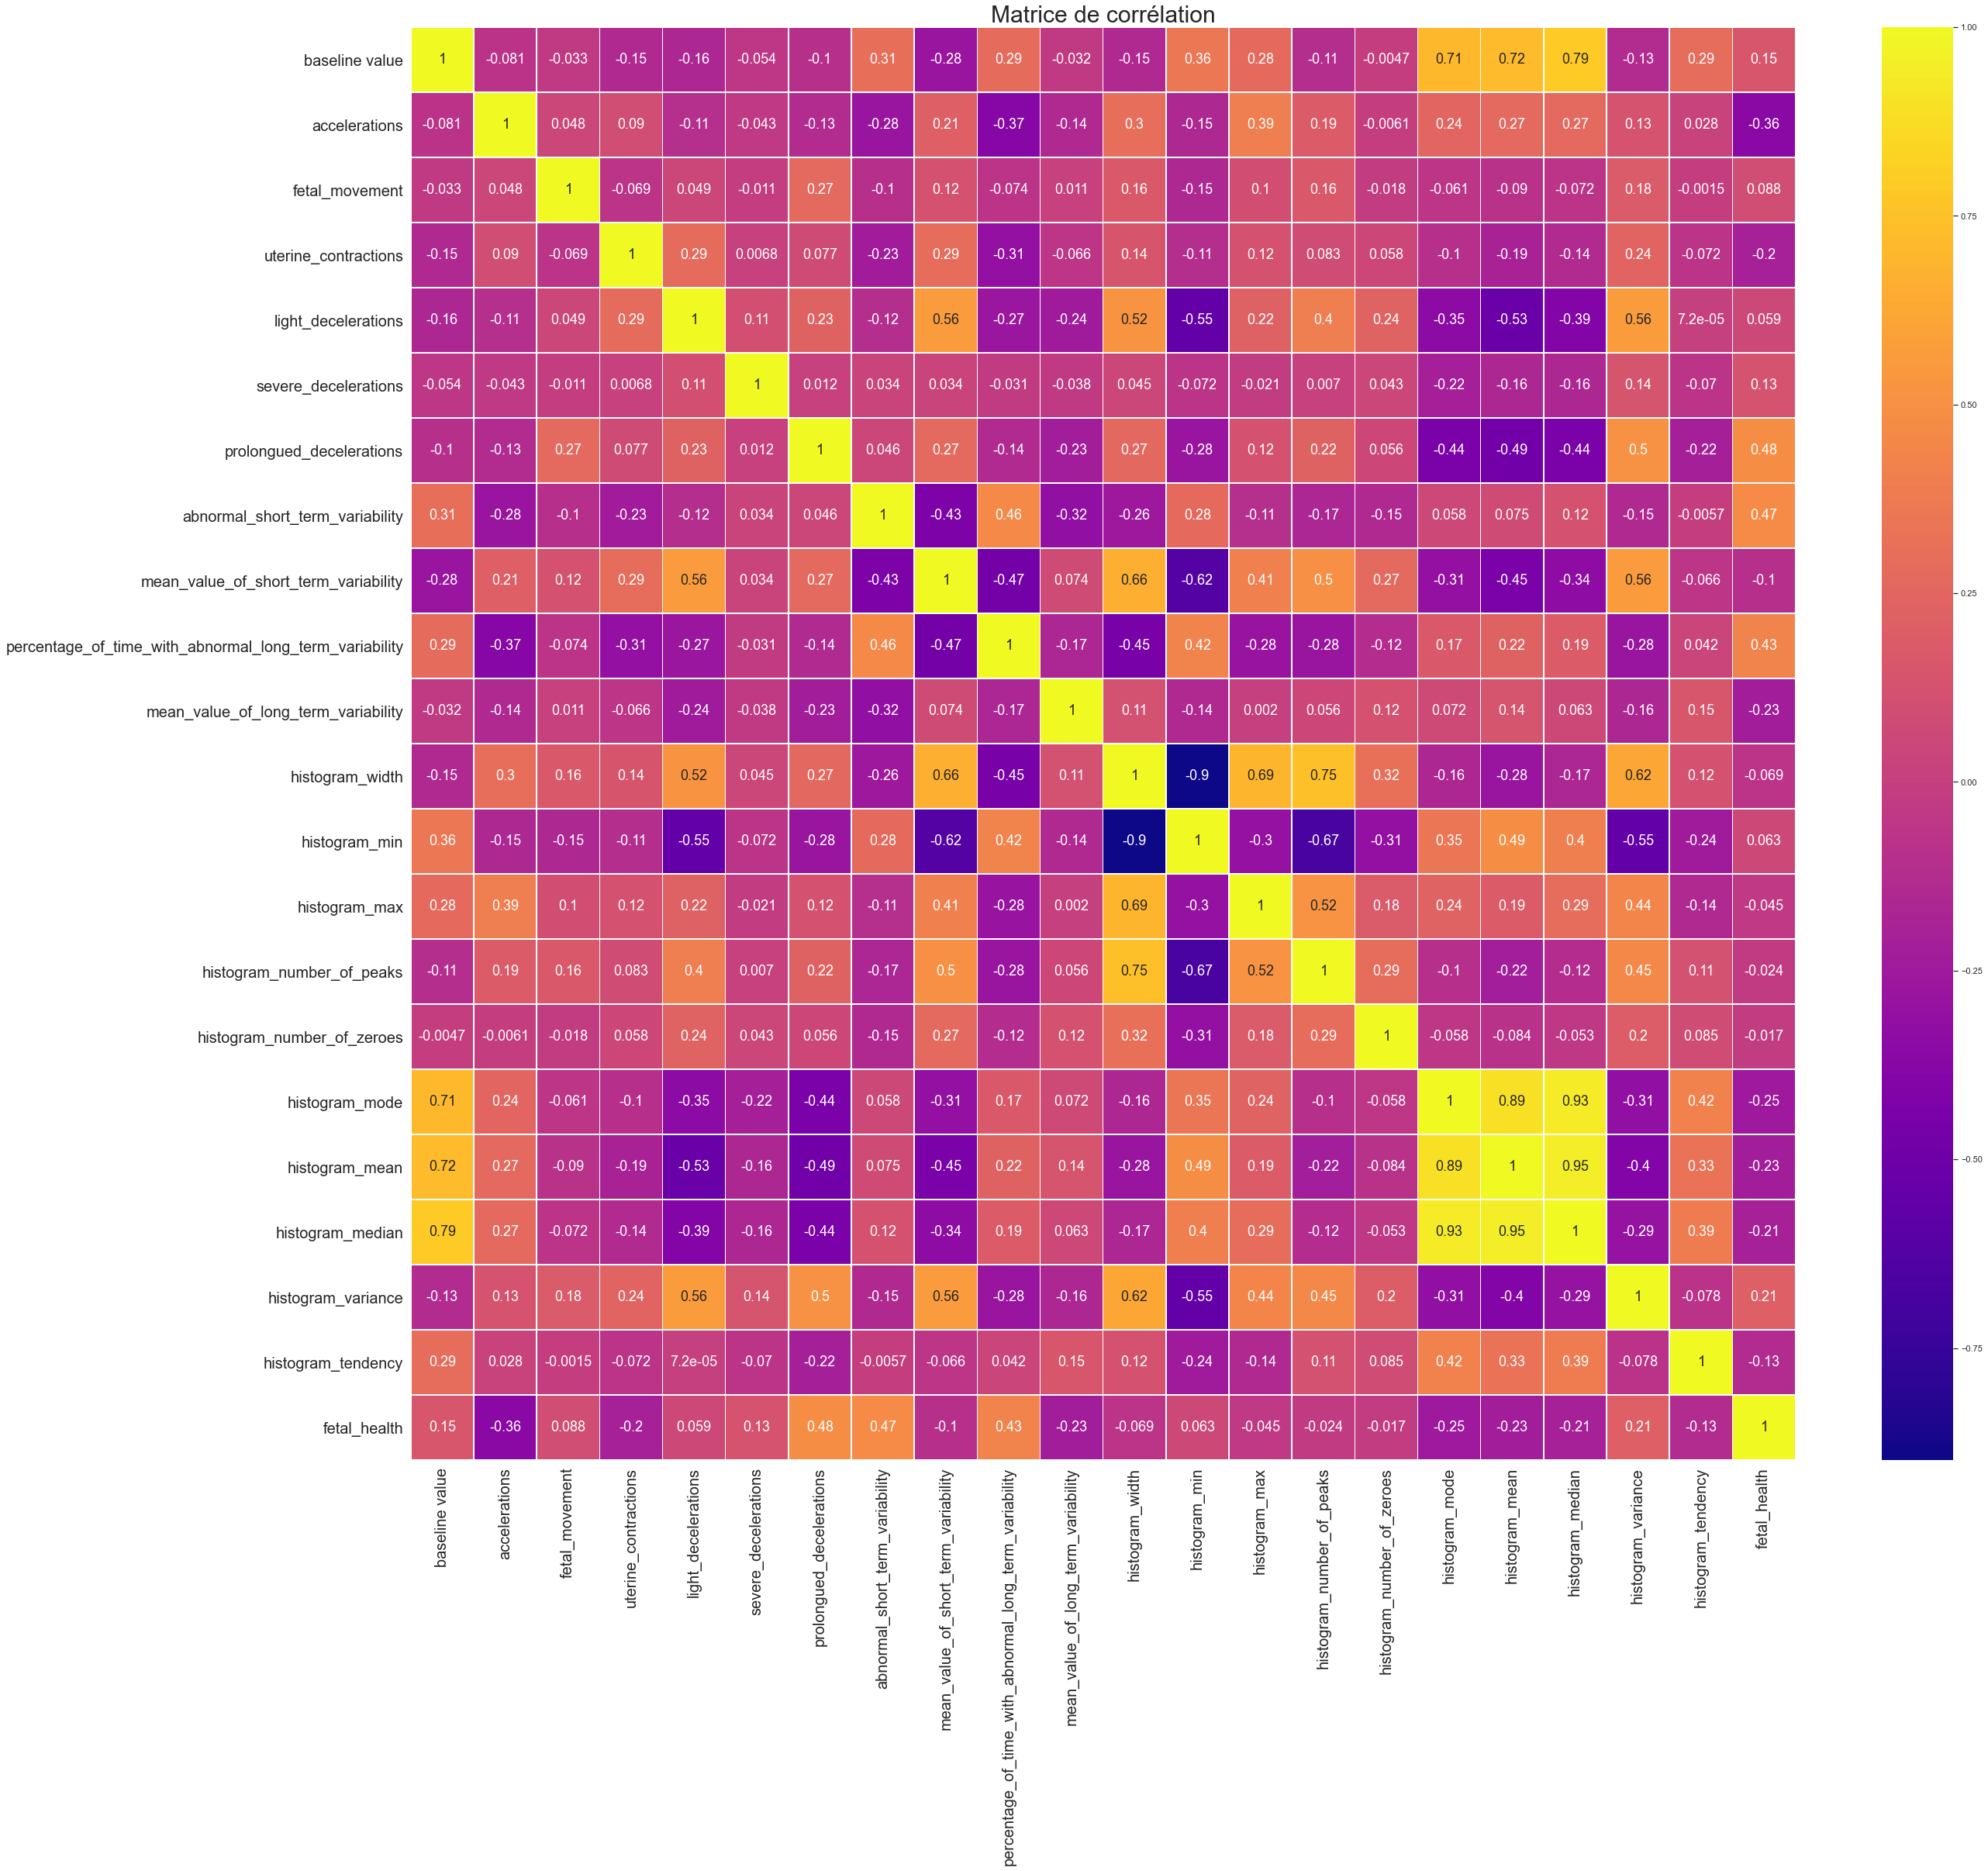

In [133]:
#Matrice de corrélation
plt.figure(figsize = (40,34))
corrMatrix = health_dataset.corr()
sns.set(font_scale=1)
sns.heatmap(corrMatrix, 
        xticklabels=corrMatrix,
        yticklabels=corrMatrix,
        linewidths=.5,
        annot=True,
        annot_kws={"size": 18},
        cmap = 'plasma')
plt.title('Matrice de corrélation', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

Il y'a un nombre important de features, pour choisir les variables utilisées dans le modèle, on peut tracer la matrice de corrélation et choisir les features les plus corrélées a 'fetal_health' (notre variable y). 

In [102]:
columns = ['prolongued_decelerations', 'abnormal_short_term_variability', 'histogram_variance', 'fetal_health'] #Choix des features
health_dataset = health_dataset[columns] # On créer un sous dataset contenant nos features et notre target
health_dataset.dropna() # On enlève les nulls

,prolongued_decelerations,abnormal_short_term_variability,histogram_variance,fetal_health
0,0.0,73.0,73.0,2.0
1,0.0,17.0,12.0,1.0
2,0.0,16.0,13.0,1.0
3,0.0,16.0,13.0,1.0
4,0.0,16.0,11.0,1.0
...,...,...,...,...
2121,0.0,79.0,2.0,2.0
2122,0.0,78.0,3.0,2.0
2123,0.0,79.0,4.0,2.0
2124,0.0,78.0,4.0,2.0


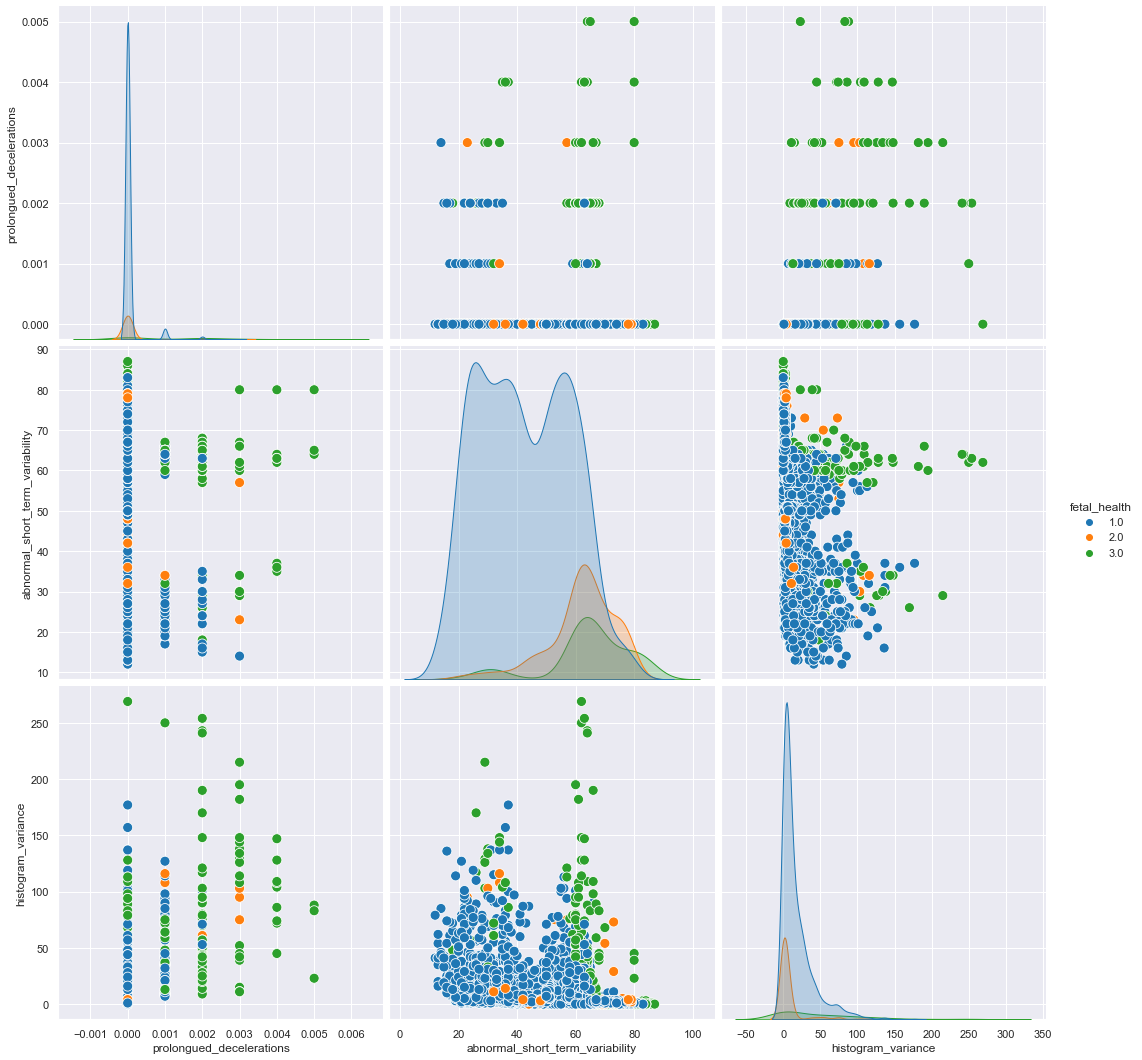

In [103]:
sns.pairplot(health_dataset, hue = 'fetal_health', palette = 'tab10', kind = 'scatter', diag_kind = 'kde',
             height = 5, plot_kws={"s": 100})

Sur le graphique ci dessus, on peut observer les différentes relations entre nos variables et les distributions de celles-ci. La couleur indique à quelle catégorie de 'fetal_health' le bébé appartient. Par exemple, on observe que les bébé avec un 'histogram_variance' élevé sont plus souvent 'Pathologic', de même que lorsque le nombre de 'prolongued_decelerations' augmente.

## Implémentation du modèle

### Sous modèles

In [104]:
X_health = health_dataset[['prolongued_decelerations', 'histogram_variance']].values
y_health = health_dataset['fetal_health'].values
y_health = y_health.reshape((y_health.shape[0],1))
X_health = (X_health-np.mean(X_health))/np.std(X_health)
X_health = np.hstack((X_health, np.ones((X_health.shape[0],1))))

theta_1,  theta_2 =  np.random.rand(X_health.shape[1],1) , np.random.rand(X_health.shape[1],1)

In [105]:
# On sépare notre problème en 2 régression logistique simple, il faut donc 2 y_health différents : 
y_health
y_health_1, y_health_2 = np.zeros(y_health.shape), np.zeros(y_health.shape)
for i in range(y_health.shape[0]):
    if y_health[i] == 2:
        y_health_1[i] = 1
    elif y_health[i] == 3:
        y_health_2[i] = 1

Comme dit précedemment, on sépare ici notre problème en deux régression logistique simple. On aura alors :
- $h1_\theta(x)$ qui va donner une probabilité estimée que le bébé soit 'Suspect'
- $h2_\theta(x)$ qui va donner une probabilité estimée que le bébé soit 'Pathological'  
Il est possible de faire la matrice de confusion de nos 2 sous modèles pour en observer la précision :

In [106]:
theta_1, listInutile = gradient_descent(X_health, theta_1, y_health_1)
theta_2, listInutile = gradient_descent(X_health, theta_2, y_health_2)
pred1 = predictions(X_health, theta_1)
pred2 = predictions(X_health, theta_2)

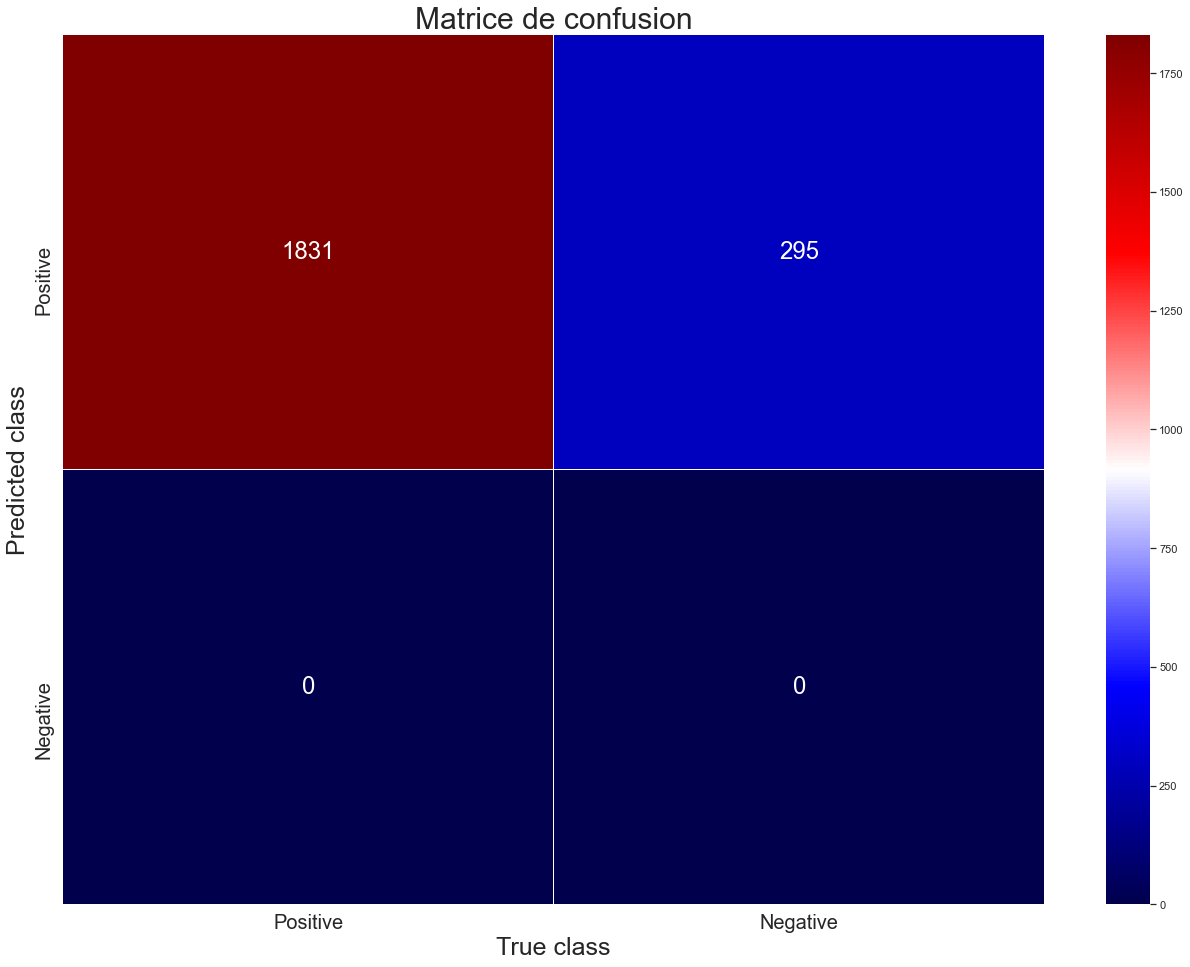

Accuracy = 0.861241768579492


array([[1831.,  295.],
       [   0.,    0.]])

In [134]:
confusion_Matrix(pred1, y_health_1)

On observe un taux de précision de 86% ce qui est très bon pour le premier sous modèle.

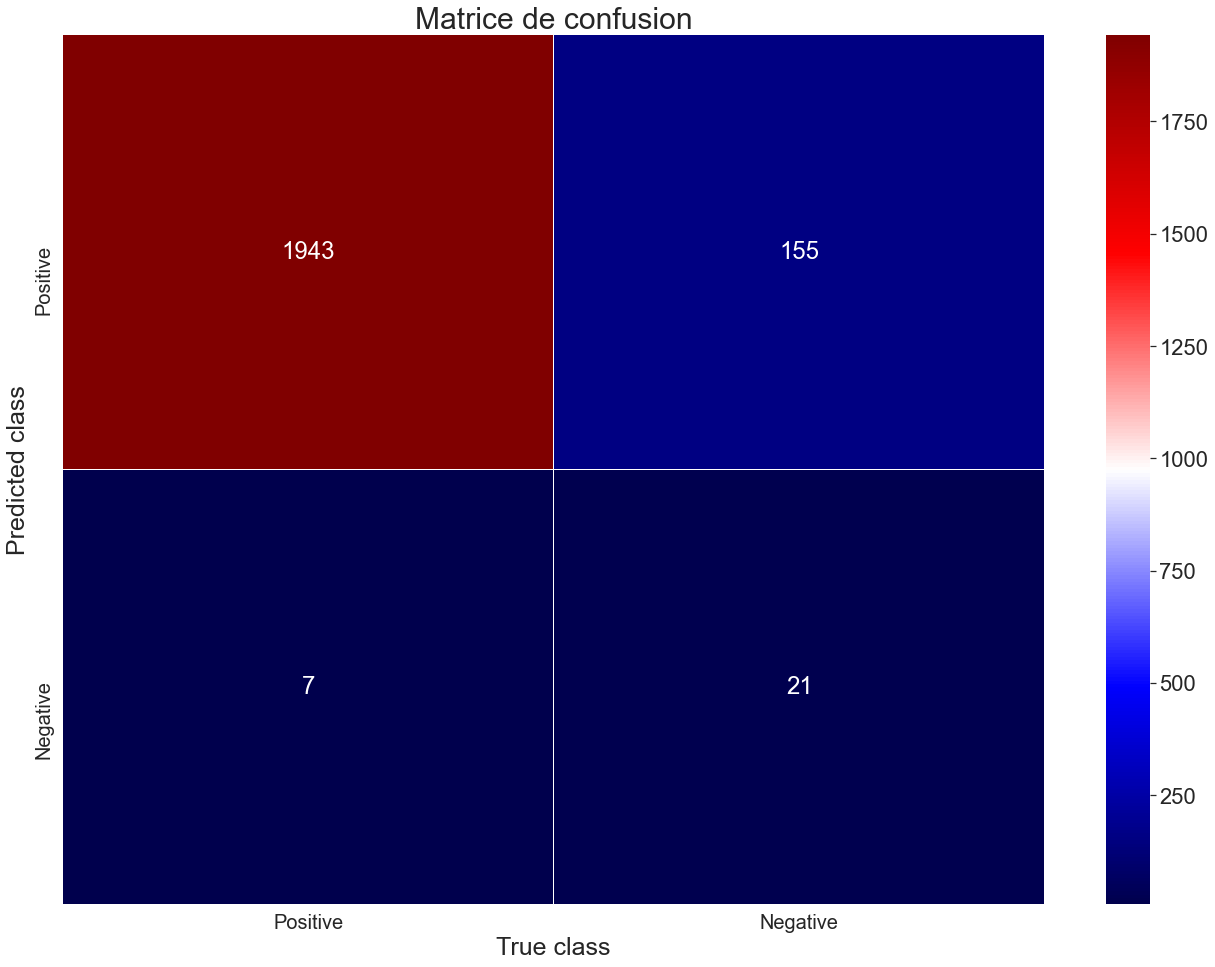

Accuracy = 0.9238005644402634


array([[1943.,  155.],
       [   7.,   21.]])

In [121]:
confusion_Matrix(pred2, y_health_2)

On observe un taux de précision de 92% pour le deuxième sous modèle, ce qui est très bon également. Toutefois une trop bonne précision peut être dûe à un phénomène [d'overfitting](https://fr.wikipedia.org/wiki/Surapprentissage) ce qui peut s'avérer problématique.

### Modèle final

In [109]:
h_1 = hypothesis(X_health, theta_1)
h_2 = hypothesis(X_health, theta_2)

In [110]:
def max_duo(x, y):
    if(x < 0.5 and y < 0.5):
        return 1
    elif(x > y):
        return 2
    elif(y > x):
        return 3

Si les deux modèles renvoient des probabilités < 0.5, on considère le bébé 'normal', sinon on considère la probabilité maximum 'gagnante'.

In [111]:
pred_health = np.zeros((y_health.shape[0],1))
for i in range(h_1.shape[0]):
    pred_health[i] = (max_duo(h_1[i], h_2[i]))

### Résultats et conclusion

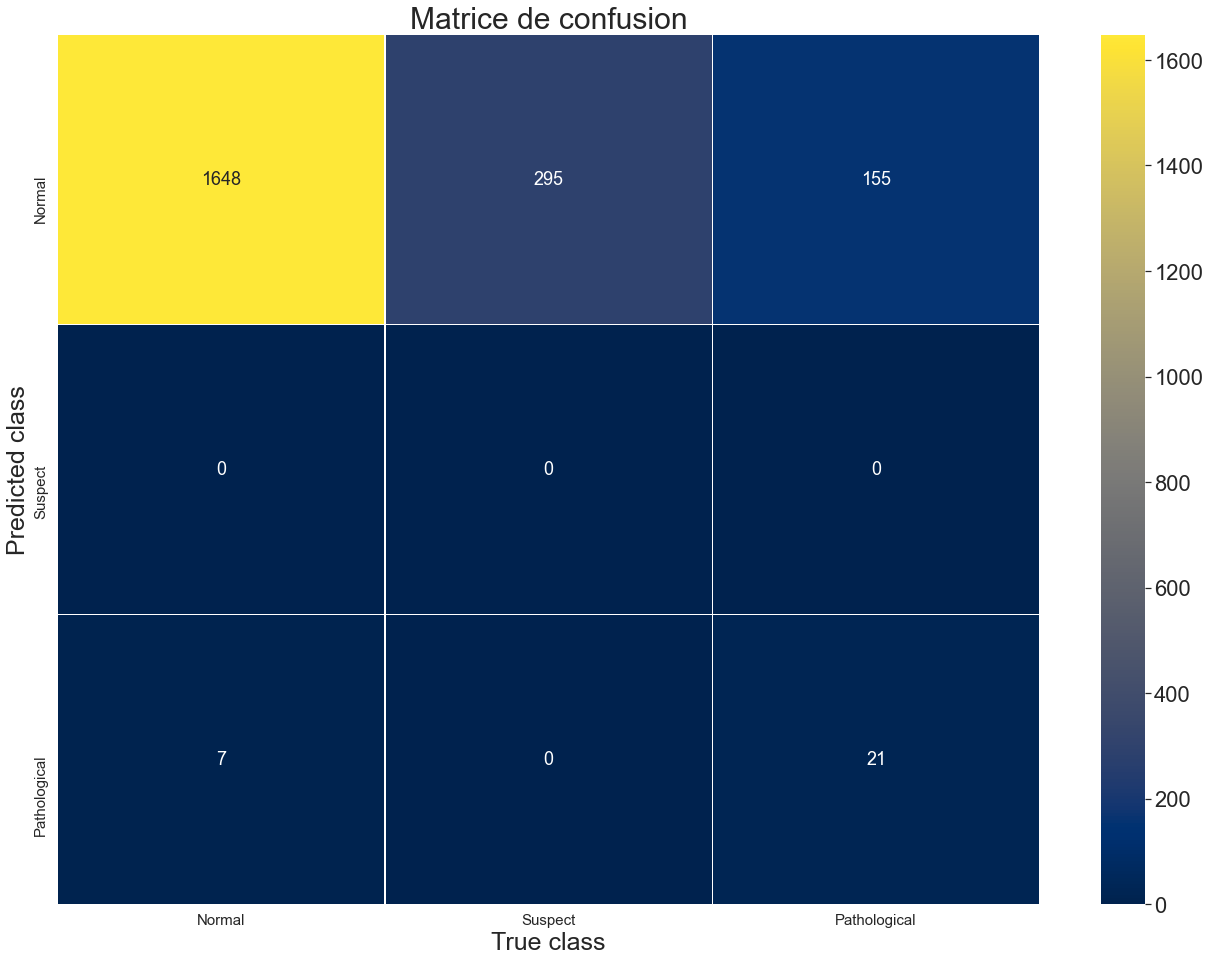

Accuracy = 0.7850423330197555


In [122]:
# Matrice de confusion
# Il faut changer un peu le code de la fonction définie précédemment
matrix = np.zeros((3,3))
for i in range(pred_health.shape[0]):
    matrix[int(pred_health[i][0])-1][int(y_health[i][0])-1] += 1
            
# Représentation graphique
plt.figure(figsize=(22,16))
sns.heatmap(matrix, 
    xticklabels=['Normal','Suspect','Pathological'],
    yticklabels=['Normal','Suspect','Pathological'],
    linewidths=.5,
    annot=True,
    annot_kws={"size": 18},
    fmt='g',
    cmap = 'cividis')
plt.title('Matrice de confusion', fontsize = 30)
plt.xlabel('True class', fontsize = 25)
plt.ylabel('Predicted class', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()
acc = np.sum(np.diag(matrix))/pred_health.shape[0]
print('Accuracy = '+str(acc))
# Notre modèle prédit juste à 65.6% du temps

Voici la matrice de confusion du résultat final obtenu. On observe un taux de précision de 78.5% ce qui est très correcte. Toutefois on peut s'interroger sur la performance réelle du modèle. En effet, du fait que la majorité des bébés soient dans un état 'Normal', le modèle classe la plupart des bébés dans ce cas (hormis 21 bébés classés 'Pathological').  
Ainsi il passe à côté de 295 bébés 'Suspect' et 155 bébés 'Pathological' commettant alors une erreur de seconde espèce. C'est pourtant précisément pour détecter les anomalies que le modèle pourrait s'avérer utile. En dépit de son score de précision important, je dirais que le modèle n'est pas vraiment efficace.

In [113]:
health_dataset['prediction'] = pred_health[:, 0]
list_temp = list()
for i in range(len(health_dataset['prediction'])):
    list_temp.append(health_dataset['prediction'][i] == health_dataset['fetal_health'][i])
health_dataset['Prediction exacte'] = list_temp

Text(0.5, 0.98, 'Exactitude des prédictions du modèle')

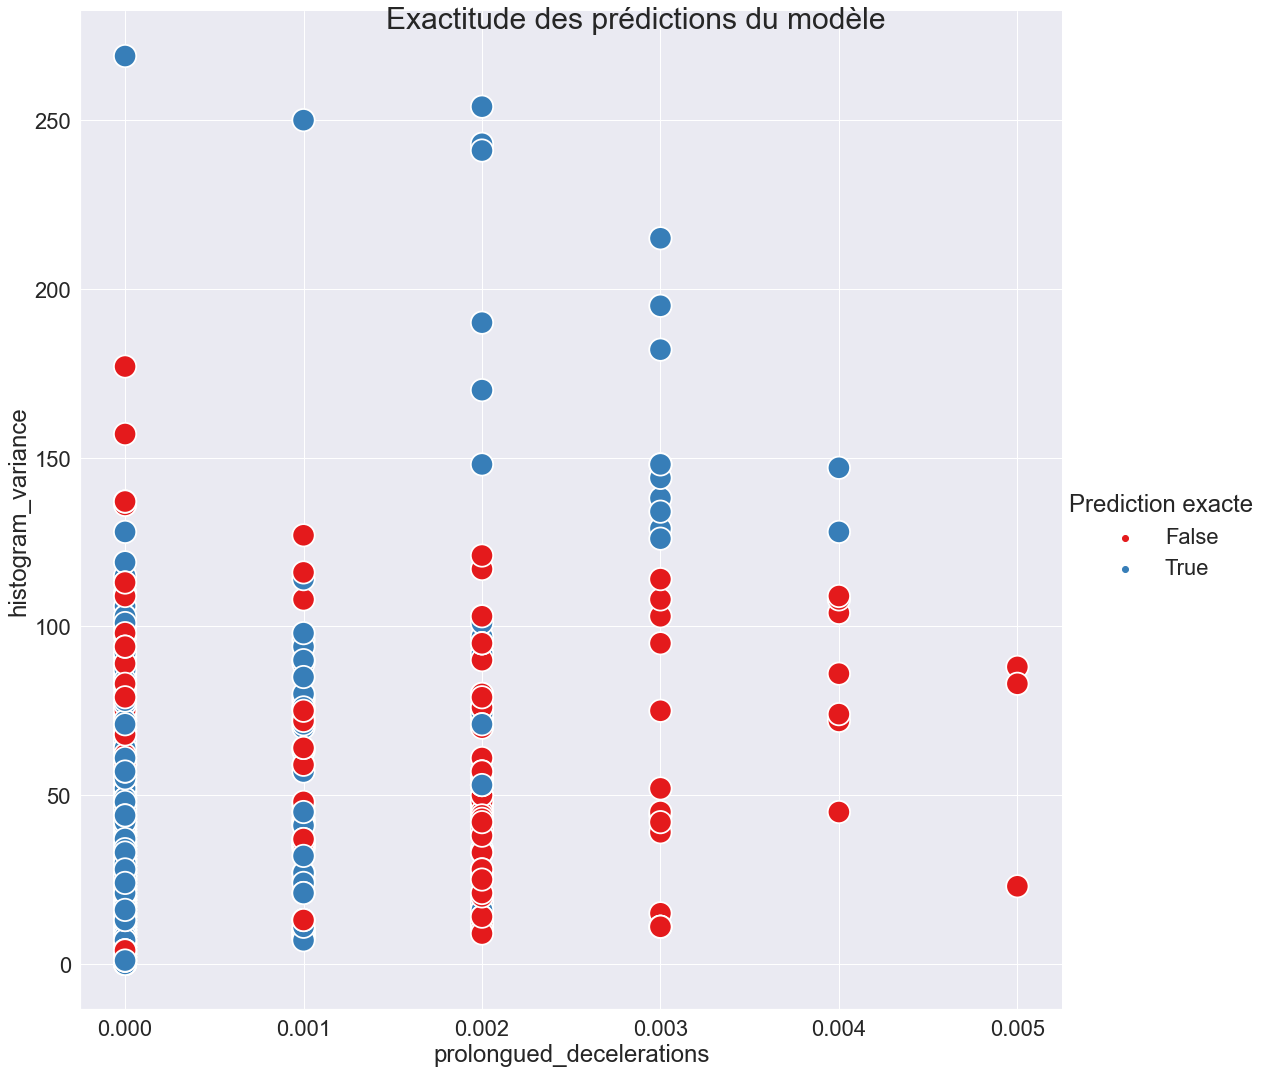

In [114]:
sns.set(font_scale=2)
g = sns.relplot(data=health_dataset, x='prolongued_decelerations', y="histogram_variance", height = 15,
            hue="Prediction exacte", kind='scatter', palette = 'Set1', s = 500)
g.fig.suptitle("Exactitude des prédictions du modèle", fontsize = 30)

Voici un graphique présentant la distribution de nos variables colorées en fonction de l'exactitude des prédictions réalisées. On observe qu'étant donnée une 'histogram_variance' similaire, le modèle n'arrive pas à prédire que le bébé avec une 'prolongued_decelerations' importante est un cas 'Pathological'.

Pour terminer, on peut également tracer la frontière de décision (voici le [lien](https://github.com/KVSSetty/ml-notebooks/blob/master/Plot%20a%20Decision%20Surface%20for%20Machine%20Learning%20Algorithms%20in%20Python/Plot%20a%20Decision%20Surface%20for%20Machine%20Learning%20Algorithms%20in%20Python.ipynb?fbclid=IwAR30OeHQRMJzhuahY639r_NThzdi6jLnS6607kuOAdjTW-bNGkJZswnbnpU) du tutoriel m'ayant permis de le faire) :

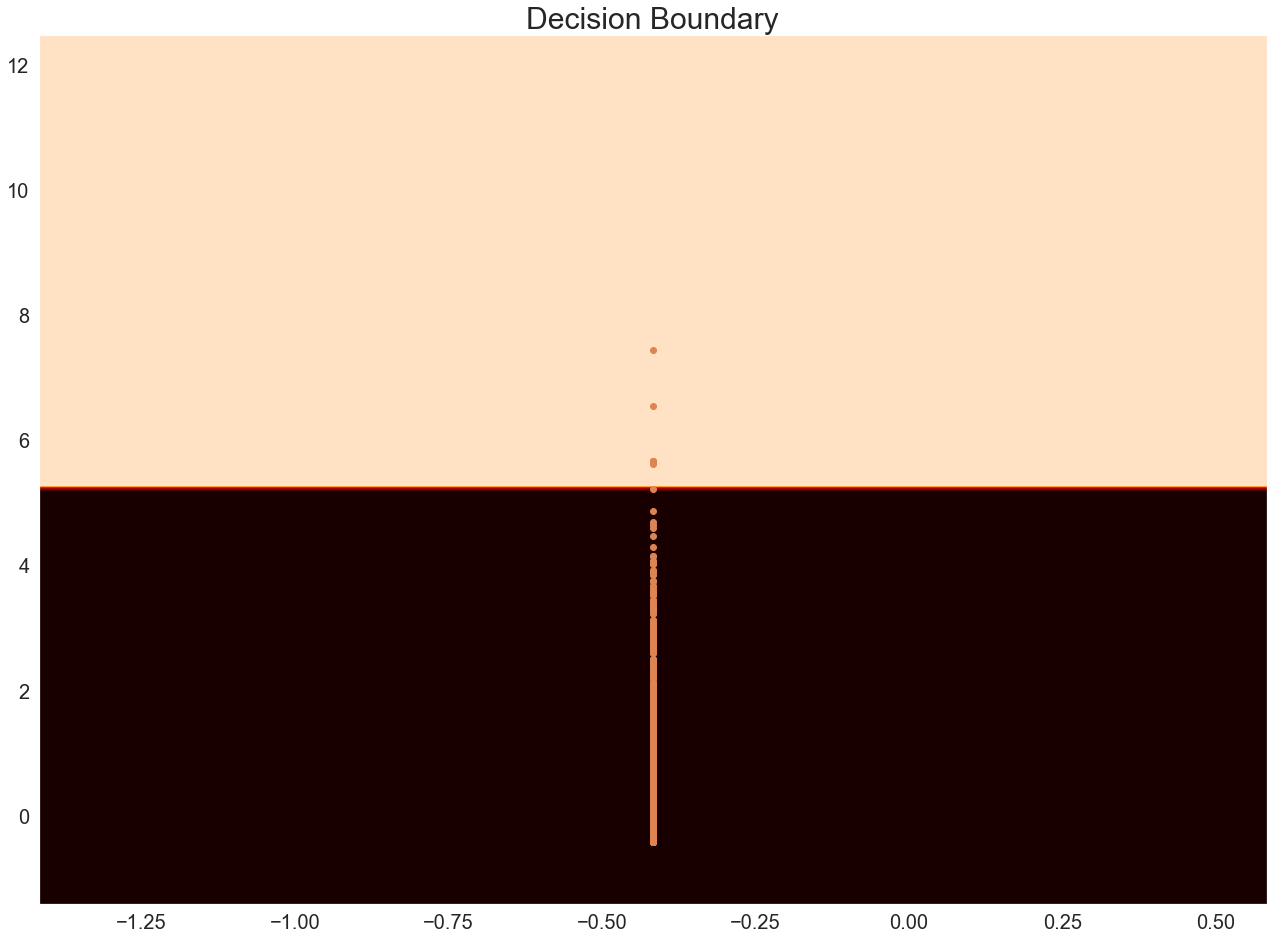

In [126]:
from sklearn.linear_model import LogisticRegression

X_health_skl = X_health[:,:2] # On enlève le biais

# define bounds of the domain
min1, max1 = X_health_skl[:, 0].min()-1, X_health_skl[:, 0].max()+1
min2, max2 = X_health_skl[:, 1].min()-1, X_health_skl[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model


# define the model
model = LogisticRegression()
# fit the model
model.fit(X_health_skl[:,:2], y_health.ravel())
# make predictions for the grid
yhat = model.predict(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.figure(figsize=(22,16))
plt.title('Decision Boundary', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.contourf(xx, yy, zz, cmap='gist_heat')
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_health == class_value)
    # create scatter of these samples
    plt.scatter(X_health_skl[row_ix, 0], X_health_skl[row_ix, 1])

Ce graphique représente la frontière de décision ou 'Décision Boundary'. Ce que nous dit ce graphique, c'est que tous les points situés au dessus de la ligne seront considérés comme 'Pathological' dans notre modèle et tous les points en dessous seront 'Normal'. Cela confirme donc bien ce que nous avons pu voir avec la matrice de confusion tracée plus tôt à savoir que la majorité des points sont considérés comme 'Normal'.     
A noter qu'il ne s'agit pas de la distribution de point la plus intéressante ni même de la decision boundary la plus intéressante (car il s'agit d'un modèle linéaire). Mais ce graphique permet néanmoins une bonne visualisation des choses.